## Importação dos pacotes

In [50]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [51]:
# definir parâmetros extras
#pd.set_option('precision', 2)
pd.set_option('display.max_columns', 100)

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
# importar pacotes usados na seleção do modelo e na medição da precisão
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix

# importar os pacotes necessários para os algoritmos de regressão
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

## Carga dos dados de entrada

In [93]:
# carregar arquivo de dados de treino
filename = 'abalone-train.csv'
#filename = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-abalone/abalone-train.csv'
data = pd.read_csv(filename, index_col='id')

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.head()

(2784, 9)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
2758,M,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10
1384,F,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9
1131,M,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8
3726,I,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8
3445,I,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8


In [94]:
data_sex = pd.get_dummies(data['sex'], prefix='sex')

cols = {}
for col in data_sex.columns:
    cols[col] = col.lower()
data.rename(columns=cols, inplace=True)

data_sex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2784 entries, 2758 to 852
Data columns (total 3 columns):
sex_F    2784 non-null uint8
sex_I    2784 non-null uint8
sex_M    2784 non-null uint8
dtypes: uint8(3)
memory usage: 29.9 KB


In [95]:
data = data.join(data_sex)
data.drop('sex', axis=1, inplace=True)
data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
id,,,,,,,,,,,
2758,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10,0,0,1
1384,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9,1,0,0
1131,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8,0,0,1
3726,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8,0,1,0
3445,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8,0,1,0


In [96]:
# excluir dados com valores inválidos
outliers = np.concatenate((
    data[data.height == 0.0].index,
    data[(data['viscera_weight'] > 0.5) & (data['rings'] < 20 - 1.5)].index,
    data[(data['viscera_weight'] < 0.5) & (data['rings'] > 25 - 1.5)].index,
    data[(data['shell_weight'] > 0.6) & (data['rings'] < 25 - 1.5)].index,
    data[(data['shell_weight'] < 0.8) & (data['rings'] > 25 - 1.5)].index,
    data[(data['shucked_weight'] >= 1.0) & (data['rings'] < 20 - 1.5)].index,
    data[(data['shucked_weight'] < 1.0)  & (data['rings'] > 20 - 1.5)].index,
    data[(data['whole_weight'] >= 2.5) & (data['rings'] < 25 - 1.5)].index,
    data[(data['whole_weight'] < 2.5)  & (data['rings'] > 25 - 1.5)].index,
    data[(data['diameter'] < 0.1)  & (data['rings'] < 5 - 1.5)].index,
    data[(data['diameter'] < 0.6)  & (data['rings'] > 25 - 1.5)].index,
    data[(data['diameter'] >= 0.6) & (data['rings'] < 25 - 1.5)].index,
    data[(data['height'] > 0.4) & (data['rings'] < 15 - 1.5)].index,
    data[(data['height'] < 0.4) & (data['rings'] > 25 - 1.5)].index,
    data[(data['length'] < 0.1)  & (data['rings'] < 5 - 1.5)].index,
    data[(data['length'] < 0.8)  & (data['rings'] > 25 - 1.5)].index,
    data[(data['length'] >= 0.8) & (data['rings'] < 25 - 1.5)].index
), axis=0)

In [97]:
print("Número de outliers a serem removidos: %d" % len(outliers))

print("Antes:", data.shape)
data.drop(outliers, inplace=True)
print("Depois:", data.shape)

Número de outliers a serem removidos: 171
Antes: (2784, 11)
Depois: (2672, 11)


In [98]:
# definir dados de entrada

X = data.drop(['rings'], axis=1) # tudo, exceto a coluna alvo
y = data['rings'] # apenas a coluna alvo

print('Forma dos dados originais:', X.shape, y.shape)

Forma dos dados originais: (2672, 10) (2672,)


## Treinamento dos modelos preditivos

In [60]:
from sklearn.metrics import make_scorer, mean_squared_error

# cria função para cálculo do RMSE (REMQ)
def root_mean_squared_error(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(root_mean_squared_error, greater_is_better=False)

In [61]:
from datetime import datetime

# avalia o desempenho do modelo, retornando o valor do RMSE
def evaluate_model_cv(model, X=X, y=y):
    start = datetime.now()
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_val_score(model, X, y, cv=kfold, scoring=RMSE, verbose=1)
    end = datetime.now()
    elapsed = int((end - start).total_seconds() * 1000)
    score = (-1) * results.mean()
    stddev = results.std()
    print(model, '\nScore: %.2f (+/- %.2f) [%5s ms]' % (score, stddev, elapsed))
    return score, stddev, elapsed

In [62]:
# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X=X, y=y):
  print('\nFine Tuning Model:')
  print(model, "\nparams:", params)

  kfold = KFold(n_splits=10, random_state=42)
  grid = GridSearchCV(estimator=model, param_grid=params, scoring=RMSE, cv=kfold, verbose=1)
  grid.fit(X, y)

  print('\nGrid Best Score: %.2f' % (grid.best_score_ * (-1)))
  print('Best Params:', grid.best_params_)
 
  return grid

## Avaliação e ajuste fino de cada modelo preditivo

-  https://scikit-learn.org/stable/modules/classes.html

### Generalized Linear Models

In [16]:
model = LinearRegression(n_jobs=2, fit_intercept=False, normalize=True)
evaluate_model_cv(model)

params = dict(
    fit_intercept=[True, False],
    normalize=[True, False]
)
fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=2, normalize=True) 
Score: 1.92 (+/- 0.16) [ 1607 ms]

Fine Tuning Model:
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=2, normalize=True) 
params: {'fit_intercept': [True, False], 'normalize': [True, False]}
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Grid Best Score: 1.92
Best Params: {'fit_intercept': False, 'normalize': True}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.1s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=2, normalize=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(root_mean_squared_error, greater_is_better=False),
       verbose=1)

In [63]:
model = LogisticRegression(n_jobs=2, random_state=42, multi_class='auto', C=1000, solver='newton-cg')
evaluate_model_cv(model)

params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C':np.logspace(-3,3,7)
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto', n_jobs=2,
          penalty='l2', random_state=42, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 
Score: 2.09 (+/- 0.17) [286409 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.8min finished


In [64]:
model = OrthogonalMatchingPursuit(n_nonzero_coefs=8, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = {
    'n_nonzero_coefs': [None, 1, 2, 4, 6, 8, 10],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=8,
             normalize=True, precompute='auto', tol=None) 
Score: 1.91 (+/- 0.16) [  467 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [152]:
model = PassiveAggressiveRegressor(random_state=42, C=0.1, fit_intercept=True, max_iter=1000, tol=0.001)
evaluate_model_cv(model)

params = {
    'C': [0.1, 0.2, 0.4, 0.8, 1.0],
    'fit_intercept': [True, False],
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


PassiveAggressiveRegressor(C=0.1, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=1000, n_iter=None, n_iter_no_change=5,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.01 (+/- 0.16) [  750 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [153]:
model = Perceptron(random_state=42, penalty='l2', alpha=1e-5, fit_intercept=True, max_iter=1000, tol=1e-3)
evaluate_model_cv(model)

#penalty=None, alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, 
#random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=1e-05, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=1000, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty='l2', random_state=42, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.98 (+/- 0.67) [ 3395 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


In [67]:
model = RANSACRegressor(random_state=42, min_samples=0.75)
evaluate_model_cv(model)

#base_estimator=None, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None, max_trials=100, 
#max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss=’absolute_loss’, random_state=None

params = {
    'min_samples': [None, 0.1, 0.25, 0.5, 0.75, 1.0]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=0.75, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 1.94 (+/- 0.17) [13687 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.7s finished


In [68]:
model = Ridge(random_state=42, alpha=0.1, fit_intercept=False, normalize=True)
evaluate_model_cv(model)

#alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’, random_state=None

params = {
    'alpha': np.logspace(-6, -1, 4),
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=42, solver='auto', tol=0.001) 
Score: 1.92 (+/- 0.16) [  392 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [154]:
model = SGDRegressor(random_state=42, alpha=1e-06, fit_intercept=True, penalty=None, tol=1e-3)
evaluate_model_cv(model)

#loss=’squared_loss’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, 
#verbose=0, epsilon=0.1, random_state=None, learning_rate=’invscaling’, eta0=0.01, power_t=0.25, early_stopping=False, 
#validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 4),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False) 
Score: 2.01 (+/- 0.17) [ 6103 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished


In [70]:
model = TheilSenRegressor(random_state=42, n_jobs=2, fit_intercept=True)
evaluate_model_cv(model)

#fit_intercept=True, copy_X=True, max_subpopulation=10000.0, n_subsamples=None, 
#max_iter=300, tol=0.001, random_state=None, n_jobs=None, verbose=False

params = {
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=2, n_subsamples=None,
         random_state=42, tol=0.001, verbose=False) 
Score: 1.93 (+/- 0.16) [104912 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


### Decision Trees

In [145]:
model = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)
evaluate_model_cv(model)

#criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, presort=False

params = dict(
    max_depth=[4, 6, 8, 10, 12, 14],
    min_samples_split=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.25, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best') 
Score: 2.10 (+/- 0.14) [  604 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


### Gaussian Processes

In [157]:
model = GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)
evaluate_model_cv(model)

#kernel=None, alpha=1e-10, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0,
#normalize_y=False, copy_X_train=True, random_state=None

params = dict(
    alpha=np.logspace(-6, -1, 6),
    normalize_y=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 1.84 (+/- 0.15) [128887 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished


### Kernel Ridge Regression

In [73]:
model = KernelRidge()
evaluate_model_cv(model)

#alpha=1, kernel=’linear’, gamma=None, degree=3, coef0=1, kernel_params=None

params = dict(
    alpha=np.logspace(-6, -1, 4)
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None) 
Score: 1.93 (+/- 0.16) [84656 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


### Naïve Bayes

In [78]:
model = GaussianNB(var_smoothing=0.1)
evaluate_model_cv(model)

#priors=None, var_smoothing=1e-09

params = dict(
    var_smoothing=np.logspace(-9, -1, 5)
)
fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-09) 
Score: 2.62 (+/- 0.21) [  828 ms]

Fine Tuning Model:
GaussianNB(priors=None, var_smoothing=1e-09) 
params: {'var_smoothing': array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01])}
Fitting 10 folds for each of 5 candidates, totalling 50 fits

Grid Best Score: 2.52
Best Params: {'var_smoothing': 0.1}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.3s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_smoothing': array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(root_mean_squared_error, greater_is_better=False),
       verbose=1)

### Nearest Neighbors

In [155]:
model = KNeighborsRegressor(n_jobs=2, n_neighbors=13, weights='distance')
evaluate_model_cv(model)

#n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’,
#metric_params=None, n_jobs=None

params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=2, n_neighbors=13, p=2,
          weights='distance') 
Score: 1.93 (+/- 0.16) [ 8286 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished


### Support Vector Machines

In [132]:
model = SVR(gamma='auto', kernel='linear')
evaluate_model_cv(model)

#kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, 
#epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.00 (+/- 0.18) [17234 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


### Neural network models

In [150]:
model = MLPRegressor(random_state=42, max_iter=500,
                     activation='logistic', hidden_layer_sizes=(50,), solver='lbfgs')
evaluate_model_cv(model)

#hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, 
#learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
#random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10

params = dict(
    hidden_layer_sizes=[(100,), (50,), (50,2)],
    activation=['identity', 'logistic', 'tanh', 'relu'],
    solver=['lbfgs', 'sgd', 'adam']
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 1.83 (+/- 0.14) [304321 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.1min finished


### Ensemble Methods

In [134]:
model = RandomForestRegressor(random_state=42, n_jobs=2, n_estimators=100, max_depth=7)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
#verbose=0, warm_start=False

params = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_depth': [None, 3, 5, 7, 9, 11, 13]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 1.87 (+/- 0.14) [39921 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.9s finished


In [137]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.4, max_depth=6, max_features=10)
evaluate_model_cv(model)

#loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2,
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, 
#max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, 
#tol=0.0001

params = dict(
    n_estimators=[100, 250, 500, 750, 1000],
    max_features=[5, 7, 10],
    max_depth=[4, 6, 8, 10, 12, 14],
    learning_rate=[0.05, 0.1, 0.15, 0.2],
    subsample=[0.4, 0.6, 0.8]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.4, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 1.87 (+/- 0.15) [22094 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.1s finished


In [156]:
model = ExtraTreesRegressor(random_state=42, n_jobs=2, n_estimators=200, max_features=5)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0,
#warm_start=False

params = dict(
    n_estimators=[10, 25, 50, 75, 100, 200],
    max_features=['auto', 5, 7, 10]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
          oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 1.91 (+/- 0.15) [81651 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


In [37]:
model = BaggingRegressor(random_state=42, n_jobs=2, base_estimator=DecisionTreeRegressor())
evaluate_model_cv(model)

#base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, 
#bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0

params = dict(
    n_estimators=[10, 25, 50, 75, 100, 200],
    max_features=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=2, oob_score=False,
         random_state=42, verbose=0, warm_start=False) 
Score: 1.96 (+/- 0.11) [14629 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.6s finished


In [42]:
model = AdaBoostRegressor(random_state=42, n_estimators=100, base_estimator=DecisionTreeRegressor())
evaluate_model_cv(model)

# base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None

params = dict(
    n_estimators=[10, 25, 50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=42) 
Score: 1.94 (+/- 0.14) [88619 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


### Outros algoritmos

#### XGBoost

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [123]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=2, learning_rate=0.1,
                     n_estimators=50, max_depth=5, objective='reg:squarederror')
evaluate_model_cv(model)

#max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror',
#booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
#colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
#base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

params = dict(
    max_depth=[3, 5, 7, 9],
    n_estimators=[10, 25, 50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=2, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1) 
Score: 1.87 (+/- 0.15) [ 8407 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished


### Ensemble Learning Model

- https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e
- https://github.com/vecxoz/vecstack

In [112]:
?stacking

In [138]:
from vecstack import stacking
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Make train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize 1-st level models
ensemble_models = [
    RandomForestRegressor(random_state=42, n_jobs=2, n_estimators=100, max_depth=7),
    GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.4, max_depth=6, max_features=10),
    #ExtraTreesRegressor(random_state=42, n_jobs=2, n_estimators=100)
    XGBRegressor(random_state=42, n_jobs=2, learning_rate=0.1,
                     n_estimators=50, max_depth=5, objective='reg:squarederror')
]

# Compute stacking features
S_train, S_test = stacking(ensemble_models, X_train, y_train, X_test,
    regression=True, metric=mean_squared_error, n_folds=4, shuffle=True,
    random_state=42, verbose=2)

task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]
    fold  0:  [3.21867713]
    fold  1:  [3.40137815]
    fold  2:  [3.81335778]
    fold  3:  [3.39616608]
    ----
    MEAN:     [3.45739479] + [0.21827883]
    FULL:     [3.45728308]

model  1:     [GradientBoostingRegressor]
    fold  0:  [3.33629036]
    fold  1:  [3.40240779]
    fold  2:  [3.90560450]
    fold  3:  [3.49533086]
    ----
    MEAN:     [3.53490838] + [0.22135239]
    FULL:     [3.53481543]

model  2:     [XGBRegressor]
    fold  0:  [3.19585465]
    fold  1:  [3.37873467]
    fold  2:  [3.74717619]
    fold  3:  [3.39232352]
    ----
    MEAN:     [3.42852226] + [0.19966453]
    FULL:     [3.42841338]



In [139]:
S_train, S_test

(array([[10.77343569, 10.95453171, 11.14453697],
        [ 8.91907606,  9.11206524,  9.03664017],
        [ 7.42304753,  7.16728431,  7.3122201 ],
        ...,
        [10.72341772, 10.26489126, 10.69161701],
        [ 6.94177375,  7.19012663,  7.32061815],
        [11.1173263 , 11.44629597, 10.89840221]]),
 array([[10.30359929, 10.25293321, 10.45765591],
        [ 8.25398086,  8.2066525 ,  8.3987987 ],
        [ 9.10648941,  8.78934184,  8.89276052],
        ...,
        [10.15041936, 10.2269511 ,  9.82164645],
        [ 8.87779748,  8.41685648,  8.74126172],
        [ 4.37136961,  4.66257378,  4.20770133]]))

In [140]:
# Initialize 2-nd level model
model = XGBRegressor(random_state=42, n_jobs=2, learning_rate=0.1,
                     n_estimators=50, max_depth=5, objective='reg:squarederror')

# Fit 2-nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % mean_squared_error(y_test, y_pred) ** 0.5)

Final prediction score: [1.98277962]


## Comparação final entre os algoritmos

In [158]:
models = []

# Generalized Linear Models
models.append(('LinReg', LinearRegression(n_jobs=2, fit_intercept=False, normalize=True)))
models.append(('LogReg', LogisticRegression(n_jobs=2, random_state=42, multi_class='auto', C=1000, solver='newton-cg')))
models.append(('OMP', OrthogonalMatchingPursuit(n_nonzero_coefs=8, fit_intercept=True, normalize=True)))
models.append(('PAR', PassiveAggressiveRegressor(random_state=42, C=0.1, fit_intercept=True, max_iter=1000, tol=0.001)))
models.append(('PP', Perceptron(random_state=42, penalty='l2', alpha=1e-5, fit_intercept=True, max_iter=1000, tol=1e-3)))
models.append(('RANSAC', RANSACRegressor(random_state=42, min_samples=0.75)))
models.append(('Ridge', Ridge(random_state=42, alpha=0.1, fit_intercept=False, normalize=True)))
models.append(('SGD', SGDRegressor(random_state=42, alpha=1e-06, fit_intercept=True, penalty=None, tol=1e-3)))
models.append(('TSR', TheilSenRegressor(random_state=42, n_jobs=2, fit_intercept=True)))

# Decision Trees
models.append(('DTR', DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)))

# Gaussian Processes
models.append(('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)))

# Kernel Ridge Regression
models.append(('KRR', KernelRidge()))

# Naïve Bayes
models.append(('GNB', GaussianNB(var_smoothing=0.1)))

# Nearest Neighbors
models.append(('kNN', KNeighborsRegressor(n_jobs=2, n_neighbors=13, weights='distance')))

# Support Vector Machines
models.append(('SVM', SVR(gamma='auto', kernel='linear')))

# Neural network models
models.append(('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='logistic', hidden_layer_sizes=(50,), solver='lbfgs')))

# Ensemble Methods
models.append(('RFR', RandomForestRegressor(random_state=42, n_jobs=2, n_estimators=100, max_depth=7)))
models.append(('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.4, max_depth=6, max_features=10)))
models.append(('ETR', ExtraTreesRegressor(random_state=42, n_jobs=2, n_estimators=200, max_features=5)))
models.append(('BDTR', BaggingRegressor(random_state=42, n_jobs=2, base_estimator=DecisionTreeRegressor())))
models.append(('ABDTR', AdaBoostRegressor(random_state=42, n_estimators=100, base_estimator=DecisionTreeRegressor())))

# XGBoost
models.append(('XGBR', XGBRegressor(random_state=42, n_jobs=2, learning_rate=0.1,
                                    n_estimators=50, max_depth=5, objective='reg:squarederror')))

In [159]:
results = []
names = []
scores = []
stddevs = []
times = []

for name, model in models:
    score, stddev, elapsed = evaluate_model_cv(model, X=X, y=y)
    results.append((score, stddev))
    names.append(name)
    scores.append(score)
    stddevs.append(stddev)
    times.append(elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=2, normalize=True) 
Score: 1.92 (+/- 0.16) [ 1338 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto', n_jobs=2,
          penalty='l2', random_state=42, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 
Score: 2.09 (+/- 0.17) [311734 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=8,
             normalize=True, precompute='auto', tol=None) 
Score: 1.91 (+/- 0.16) [  786 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


PassiveAggressiveRegressor(C=0.1, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=1000, n_iter=None, n_iter_no_change=5,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.01 (+/- 0.16) [  733 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=1e-05, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=1000, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty='l2', random_state=42, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.98 (+/- 0.67) [ 4277 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=0.75, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 1.94 (+/- 0.17) [38512 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=42, solver='auto', tol=0.001) 
Score: 1.92 (+/- 0.16) [  452 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False) 
Score: 2.01 (+/- 0.17) [ 5996 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=2, n_subsamples=None,
         random_state=42, tol=0.001, verbose=False) 
Score: 1.93 (+/- 0.16) [110236 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.25, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best') 
Score: 2.10 (+/- 0.14) [  589 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 1.84 (+/- 0.15) [125666 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None) 
Score: 1.93 (+/- 0.16) [59747 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianNB(priors=None, var_smoothing=0.1) 
Score: 2.52 (+/- 0.18) [  723 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=2, n_neighbors=13, p=2,
          weights='distance') 
Score: 1.93 (+/- 0.16) [ 1724 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.00 (+/- 0.18) [18015 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 1.83 (+/- 0.14) [627358 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   41.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 1.87 (+/- 0.14) [41300 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.4, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 1.87 (+/- 0.15) [22300 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   56.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
          oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 1.91 (+/- 0.15) [56817 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=2, oob_score=False,
         random_state=42, verbose=0, warm_start=False) 
Score: 1.96 (+/- 0.11) [ 5932 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=42) 
Score: 1.94 (+/- 0.14) [88244 ms]
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=2, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1) 
Score: 1.87 (+/- 0.15) [14980 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


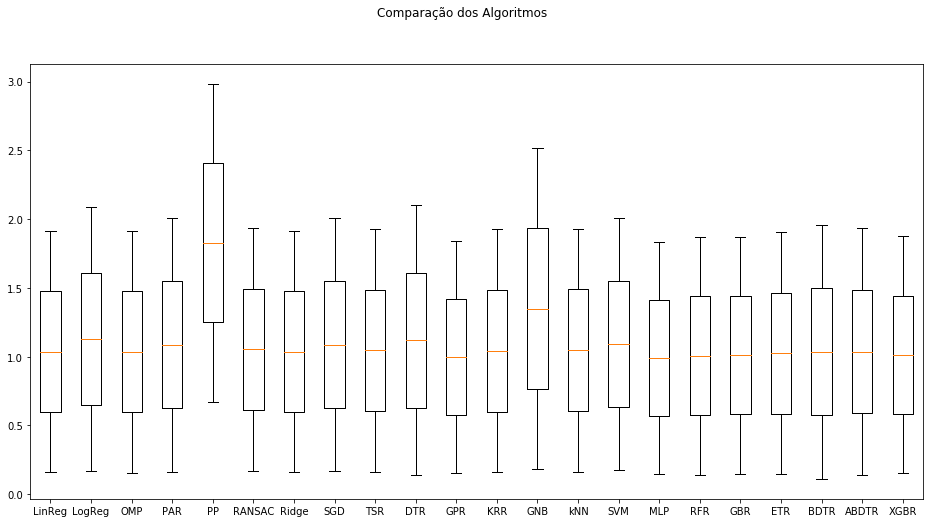

In [160]:
# comparar desempenhos dos algoritmos
fig = plt.figure(figsize=(16,8))
fig.suptitle('Comparação dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [161]:
results_df = pd.DataFrame({'Model': names, 'Score': scores, 'Std Dev': stddevs, 'Time (ms)': times})
results_df.sort_values(by='Score', ascending=True)

,Model,Score,Std Dev,Time (ms)
15,MLP,1.834466,0.144251,627358
10,GPR,1.840256,0.153970,125666
17,GBR,1.871979,0.150444,22300
16,RFR,1.873725,0.141485,41300
21,XGBR,1.874505,0.153022,14980
18,ETR,1.906015,0.146899,56817
2,OMP,1.914599,0.158312,786
6,Ridge,1.915394,0.158448,452
0,LinReg,1.915478,0.158654,1338
11,KRR,1.927149,0.158742,59747
